## (1) Datenerhebung mittels Web Scraping UND Web API

Hier wird geprüft, ob der Ordner Projektarbeit_ADS_Gruppe1 im Pfad /content bereits existiert. Wenn er nicht vorhanden ist, wird der Ordner erstellt und eine Bestätigung ausgegeben. Andernfalls wird eine Nachricht ausgegeben, die bestätigt, dass der Ordner bereits vorhanden ist.

In [1]:
import os

folder_path = "/content/Projektarbeit_ADS_Gruppe1"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Ordner {folder_path} wurde erfolgreich erstellt.")
else:
    print(f"Ordner {folder_path} existiert bereits.")

Ordner /content/Projektarbeit_ADS_Gruppe1 existiert bereits.


In [2]:
#@title 1.1 Web Scraping

from bs4 import BeautifulSoup
import requests
import pandas as pd
import os

# Get current working directory
print(os.getcwd())

# Add url of the page you want to scrape to urlString
urlString='https://mlsplayers.org/resources/salary-guide'

def salaryExtractor(urlString):
    # Make a request to the URL and get the content of the response
    getH = requests.get(urlString)
    h = getH.content
    
    # Create a BeautifulSoup object with the content
    soup = BeautifulSoup(h, 'html.parser')
    
    # Find the table with id 'salary-report'
    salaryTable = soup.select('table#salary-report')
    
    # Convert the HTML table to a DataFrame using pandas
    df = pd.read_html(str(salaryTable))[0]
    
    # Merge the 'First Name' and 'Last Name' columns into a single 'Name' column
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    
    # Drop the 'First Name' and 'Last Name' columns
    df = df.drop(columns=['First Name', 'Last Name'])
    
    # Save the DataFrame to a CSV file
    #timestr = time.strftime("%Y%m%d") # Get current time
    df.to_csv('01_salaries.csv', index=False, encoding='utf-8')
    
    #print(df.head(45))
    print('Data saved to 01_salary_data.csv')

salaryExtractor(urlString)


/content
Data saved to 01_salary_data.csv


In [3]:
# Get salary sources from past years

# Libraries and settings
!pip install xlwt

import requests
import xlwt
from bs4 import BeautifulSoup
import pandas as pd
import os
import time

# Get current working directory
print(os.getcwd())

# Add url of the page you want to scrape to urlString
urlString='https://mlsplayers.org/resources/salary-guide'

## Function to extract years and store them in the list
def yearExtractor(urlString):
    getH=requests.get(urlString) # Make a request to a web page, and returns response object:
    
    h=getH.content #  response.content returns the content of the response, in bytes
    #print(h)
    
    soup=BeautifulSoup(h,'html.parser') # pulling data out of HTML and XML files
    #-> gehe durch HTML-Element H mit Parser aus Library html.parser
    #print(soup)

    # find all unordered Lists
    lists = soup.find_all('ul')
    #print(lists)

    #Get desired list V2
    token = 'Download Previous Salary Guides'

    unorderedList = soup.find_all(string=token)[0].findNext('ul').find_all('li')
    #print(unorderedList)
    
    # Defining of the dataframe
    df = pd.DataFrame(columns=['Year', 'URL'])

    # Collecting Ddata
    for li in unorderedList:
        Year = li.select_one('[class="button"]').get_text()
        URL = li.select_one('[class="button"]')['href']
        #print(Year)
        #print(URL)

        df = df.append({'Year': Year, 'URL': URL}, ignore_index=True)
    #print(df)

    #Export DF
    timestr = time.strftime("%Y%m%d") # Get current time
    df.to_csv(timestr + '_salarySources.csv', index=False, encoding='utf-8')

yearExtractor(urlString)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content


<ipython-input-3-2997af47081e>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Year': Year, 'URL': URL}, ignore_index=True)
<ipython-input-3-2997af47081e>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Year': Year, 'URL': URL}, ignore_index=True)
<ipython-input-3-2997af47081e>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Year': Year, 'URL': URL}, ignore_index=True)
<ipython-input-3-2997af47081e>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Year': Year, 'URL': URL}, ignore_index=True)
<ipython-input-3-2997af47081e>:50: FutureWarning: The frame.append metho

### 1.2 Web API

Leistungsdaten der Spieler, Tore, Assist, etc. in CSV-Datei




In [4]:
#@title Libraries and settings
# Libraries
import os
import fnmatch
import locale
locale.setlocale(locale.LC_ALL,"")

import requests
import json
import urllib.request

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: /content


In [5]:
#@title Get Data
import json
import csv

# Authentication endpoint
def authenticate(username, password):
    url = "https://mlssoccerapi.com/v1/login"
    payload = json.dumps({
        "username": username,
        "password": password
    })
    headers = {'Content-Type': 'application/json'}
    response = requests.request("POST", url, headers=headers, data=payload)
    return response

# Players endpoint
def get_players(token, limit=3500):
    url = f"https://mlssoccerapi.com/players?limit={limit}"
    payload = {}
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {token}'
    }
    response = requests.request("GET", url, headers=headers, data=payload)
    return response.json()

if __name__ == "__main__":
    username = "oliverob"  # Fill in your username
    password = "SAbNZptpelXT0UMIoPXnK3Cnqz"  # Fill in your password

    auth_response = authenticate(username, password)

    if auth_response.status_code == 200:
        auth_data = json.loads(auth_response.text)
        access_token = auth_data.get("Document")

        # List of limit values to iterate through
        limits = [500, 1000, 1500, 2000, 2500, 3000, 3500]

        header_written = False

        for limit in limits:
            players_data = get_players(access_token, limit=limit)

            if not header_written:
                # Initialize the CSV file
                with open("02_players.csv", "w", newline="") as csvfile:
                    fieldnames = list(players_data["Document"][0].keys()) + ["limit"]
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    writer.writeheader()
                    header_written = True

            # Append data to the CSV file
            with open("02_players.csv", "a", newline="") as csvfile:
                fieldnames = list(players_data["Document"][0].keys()) + ["limit"]
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                for player in players_data["Document"]:
                    if player.get("league") == "Major League Soccer":
                        # exclude the player_image, country_image, league_image field
                        player.pop("player_image", None)
                        player.pop("country_image", None)
                        player.pop("league_image", None)
                        player["limit"] = limit
                        writer.writerow(player)
                        print(player)

    else:
        print("Authentication failed")


{'id': '007b7ab8-dbe0-11ed-af20-acde48001122', 'rating': '73', 'player_name': 'Gyasi Zardes', 'position': 'ST', 'club': 'Columbus Crew', 'league': 'Major League Soccer', 'pace': '85', 'shooting': '71', 'passing': '52', 'dribbling': '68', 'defending': '44', 'physical': '79', 'limit': 500}
{'id': '00bbcd34-dbe0-11ed-af20-acde48001122', 'rating': '73', 'player_name': 'Álvaro Medrán Just', 'position': 'CM', 'club': 'Chicago Fire FC', 'league': 'Major League Soccer', 'pace': '54', 'shooting': '67', 'passing': '76', 'dribbling': '72', 'defending': '62', 'physical': '57', 'limit': 500}
{'id': '01061db8-dbdf-11ed-af20-acde48001122', 'rating': '74', 'player_name': 'Jordan Morris', 'position': 'LM', 'club': 'Sounders FC', 'league': 'Major League Soccer', 'pace': '89', 'shooting': '70', 'passing': '68', 'dribbling': '73', 'defending': '38', 'physical': '81', 'limit': 500}
{'id': '01776d52-dbe8-11ed-af20-acde48001122', 'rating': '67', 'player_name': 'Derrick Jones', 'position': 'CDM', 'club': 'Hou

CSV-Datei "players.csv" in das Zielverzeichnis "/content/Projektarbeit_ADS_Gruppe1" kopieren ( sicherstellen, dass Zielverzeichnis erstellt)

In [6]:
import shutil

# Specify the source file path
src_file_path = "02_players.csv"

# Specify the destination directory path
dest_dir_path = "/content/Projektarbeit_ADS_Gruppe1"

# Copy the file to the destination directory
shutil.copy(src_file_path, dest_dir_path)

'/content/Projektarbeit_ADS_Gruppe1/02_players.csv'

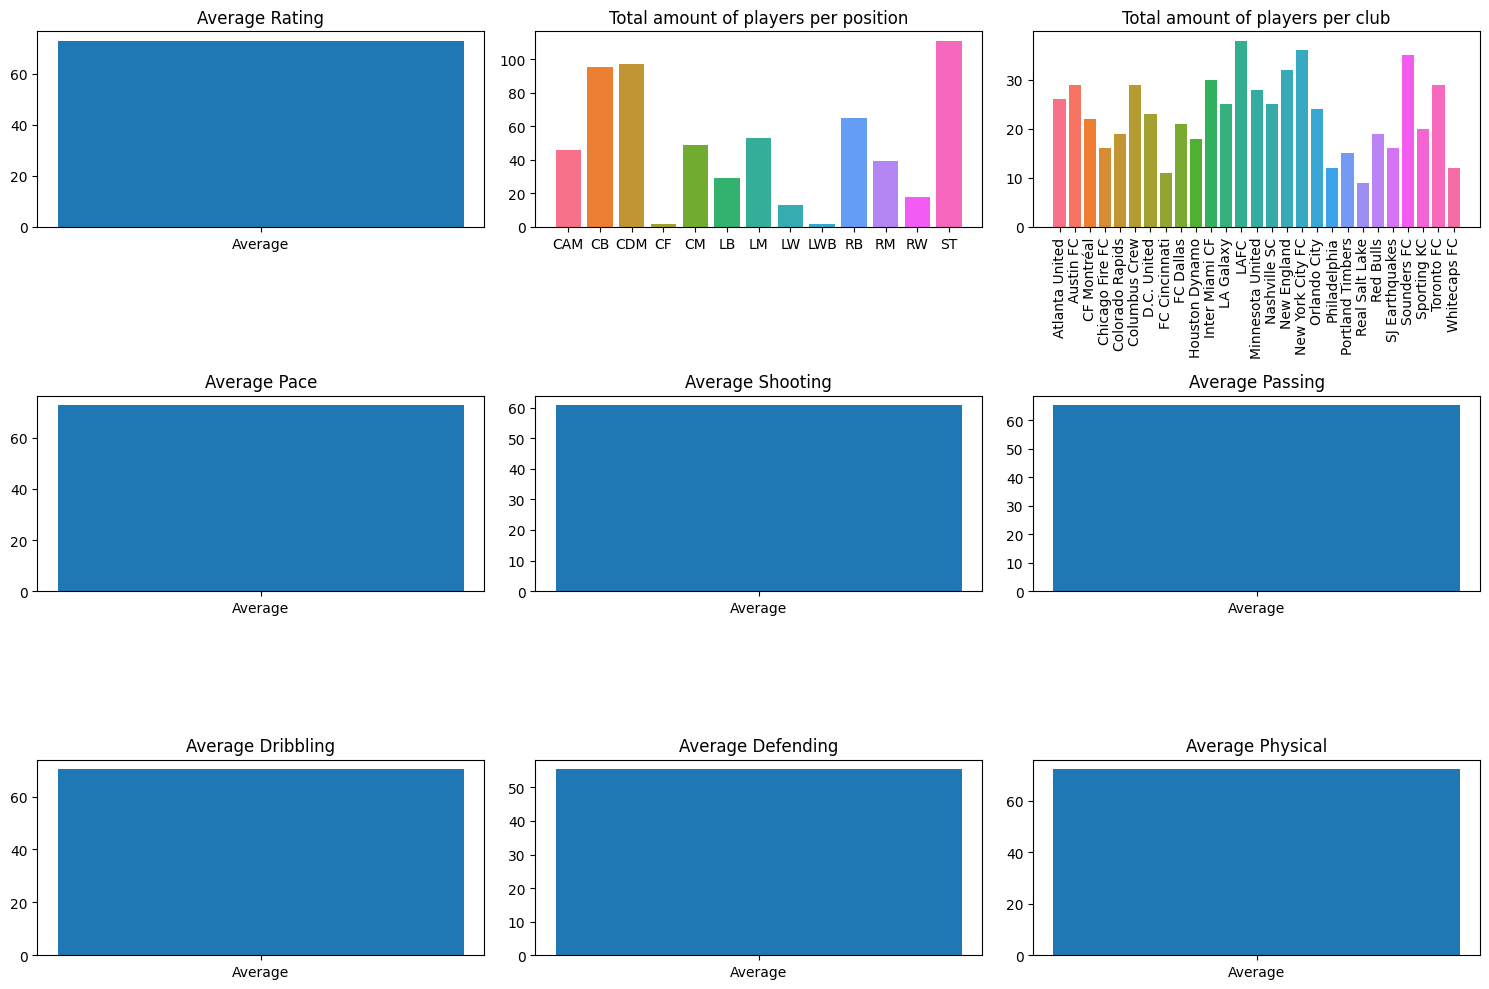

In [7]:
#@title Plot Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("02_players.csv")

# set figure size
fig = plt.figure(figsize=(15, 10))

# create color palette
positions = df["position"].unique()
clubs = df["club"].unique()
palette_pos = sns.color_palette("husl", len(positions))
palette_club = sns.color_palette("husl", len(clubs))

# Average rating
plt.subplot(3, 3, 1)
plt.bar(["Average"], [df["rating"].mean()])
plt.title("Average Rating")

# Total amount of players per position
ax1 = plt.subplot(3, 3, 2)
df_position = df.groupby("position").count()["player_name"]
ax1.bar(df_position.index, df_position.values, color=palette_pos)
ax1.set_title("Total amount of players per position")

# Total amount of players per club
ax2 = plt.subplot(3, 3, 3)
df_club = df.groupby("club").count()["player_name"]
ax2.bar(df_club.index, df_club.values, color=palette_club)
ax2.set_xticklabels(df_club.index, rotation=90)
ax2.set_title("Total amount of players per club")

# Average pace
ax3 = plt.subplot(3, 3, 4)
ax3.bar(["Average"], [df["pace"].mean()])
ax3.set_title("Average Pace")

# Average shooting
ax4 = plt.subplot(3, 3, 5)
ax4.bar(["Average"], [df["shooting"].mean()])
ax4.set_title("Average Shooting")

# Average passing
ax5 = plt.subplot(3, 3, 6)
ax5.bar(["Average"], [df["passing"].mean()])
ax5.set_title("Average Passing")

# Average dribbling
ax6 = plt.subplot(3, 3, 7)
ax6.bar(["Average"], [df["dribbling"].mean()])
ax6.set_title("Average Dribbling")

# Average defending
ax7 = plt.subplot(3, 3, 8)
ax7.bar(["Average"], [df["defending"].mean()])
ax7.set_title("Average Defending")

# Average physical
ax8 = plt.subplot(3, 3, 9)
ax8.bar(["Average"], [df["physical"].mean()])
ax8.set_title("Average Physical")

# adjust layout
fig.tight_layout()
plt.show()


## (2) Datenaufbereitung (z.B. Entfernen NAs und Duplikate, Erstellen neuer Variablen, Anreicherung der Daten, ...)

In [8]:
#@title 2.1 Merge/Zusammenführung 
import pandas as pd

def merge_csv_files(salaries_file, players_file, output_file):
    # Read the CSV files into DataFrames
    df_salaries = pd.read_csv(salaries_file)
    df_players = pd.read_csv(players_file)

    # Merge the DataFrames on a common key (assuming 'Name' column in both files)
    df_merged = pd.merge(df_salaries, df_players, left_on='Name', right_on='player_name', how='inner')

    # Save the merged DataFrame to a new CSV file
    df_merged.to_csv(output_file, index=False, encoding='utf-8')

    # Return the merged DataFrame
    return df_merged

if __name__ == "__main__":
    # Call the function to merge the CSV files and get the merged DataFrame
    merged_df = merge_csv_files('01_salaries.csv', '02_players.csv', '03_merged_data.csv')

    # Display the first 5 entries
    print(merged_df.head(5))


            Club Position(s)    Base Salary Guaranteed Compensation  \
0  FC Cincinnati           M  $1,943,500.00           $2,222,854.00   
1  FC Cincinnati           M  $1,943,500.00           $2,222,854.00   
2  FC Cincinnati           M  $1,943,500.00           $2,222,854.00   
3  FC Cincinnati           M  $1,943,500.00           $2,222,854.00   
4  FC Cincinnati           M  $1,943,500.00           $2,222,854.00   

             Name                                    id  rating  player_image  \
0  Luciano Acosta  13bd88de-dbde-11ed-af20-acde48001122      75           NaN   
1  Luciano Acosta  13bd88de-dbde-11ed-af20-acde48001122      75           NaN   
2  Luciano Acosta  13bd88de-dbde-11ed-af20-acde48001122      75           NaN   
3  Luciano Acosta  13bd88de-dbde-11ed-af20-acde48001122      75           NaN   
4  Luciano Acosta  13bd88de-dbde-11ed-af20-acde48001122      75           NaN   

      player_name  country_image  ...  position           club  \
0  Luciano Acosta   

### 2.2 Data Cleansing

Removal of empty entries within the column "Name", drop of other not needed columns (id, player_name, player_image, country_image, league_image and league) as well as removal of duplicates.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def read_csv_file(file_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    return df

def convert_currency_to_float(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def remove_missing_name_rows(df, column_name):
    df = df[df[column_name].notna()]
    return df

def remove_duplicates(df, column_name):
    df = df.drop_duplicates(subset=column_name)
    return df

def drop_columns(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop)
    return df

if __name__ == "__main__":
    # Read the merged_data.csv file
    data_df = read_csv_file('03_merged_data.csv')

    # Remove rows with missing values in the 'Name' column
    data_df = remove_missing_name_rows(data_df, 'Name')

    # Remove duplicate rows based on the 'Name' column
    data_df = remove_duplicates(data_df, 'Name')

    # Drop the specified columns
    columns_to_drop = ['player_name', 'player_image', 'id', 'country_image', 'league_image', 'league', 'Club', 'Position(s)']
    data_df = drop_columns(data_df, columns_to_drop)

    # Convert the 'Guaranteed Compensation' column to float
    data_df = convert_currency_to_float(data_df, 'Guaranteed Compensation')

    # Save the cleaned data to a new CSV file
    data_df.to_csv('04_cleaned_data.csv', index=False)

    # Display the first 5 entries after processing
    print(data_df.head(5))


      Base Salary  Guaranteed Compensation             Name  rating position  \
0   $1,943,500.00                2222854.0   Luciano Acosta      75      CAM   
6     $300,000.00                 332500.0   Harrison Afful      69       RB   
8     $150,000.00                 150000.0    Jalil Anibaba      67       CB   
10    $624,000.00                 683000.0  Cristian Arango      72       ST   
16    $575,000.00                 678750.0    Julian Araujo      69       RB   

             club  pace  shooting  passing  dribbling  defending  physical  \
0   FC Cincinnati    79        67       70         82         46        56   
6   Columbus Crew    74        58       66         69         65        70   
8   Columbus Crew    51        44       55         53         67        75   
10           LAFC    74        72       64         72         33        67   
16      LA Galaxy    80        33       60         69         64        66   

    limit  
0    1000  
6    3000  
8    3000  
10

In [10]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("04_cleaned_data.csv")

# Display data types before conversion
print("Data types before conversion:")
print(data[['Base Salary', 'Guaranteed Compensation', 'Name', 'rating', 'position', 'club', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical', 'limit']].dtypes)

# Clean data
data['Name'] = data['Name'].astype(str)
data['position'] = data['position'].astype(str)
data['club'] = data['club'].astype(str)

# Remove dollar signs, commas, and decimal places
data['Base Salary'] = data['Base Salary'].astype(str).str.replace('[\$,]', '', regex=True).astype(float).astype(int)
data['Guaranteed Compensation'] = data['Guaranteed Compensation'].astype(str).str.replace('[\$,]', '', regex=True).astype(float).astype(int)

# Display data types after conversion
print("\nData types after conversion:")
print(data[['Base Salary', 'Guaranteed Compensation', 'Name', 'rating', 'position', 'club', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical', 'limit']].dtypes)

# Save the cleaned data to a new CSV file
data.to_csv("05_cleaned_data_2.0.csv", index=False)


Data types before conversion:
Base Salary                 object
Guaranteed Compensation    float64
Name                        object
rating                       int64
position                    object
club                        object
pace                         int64
shooting                     int64
passing                      int64
dribbling                    int64
defending                    int64
physical                     int64
limit                        int64
dtype: object

Data types after conversion:
Base Salary                 int64
Guaranteed Compensation     int64
Name                       object
rating                      int64
position                   object
club                       object
pace                        int64
shooting                    int64
passing                     int64
dribbling                   int64
defending                   int64
physical                    int64
limit                       int64
dtype: object


##(3) Umfangreiche Explorative Datenanalyse (EDA)

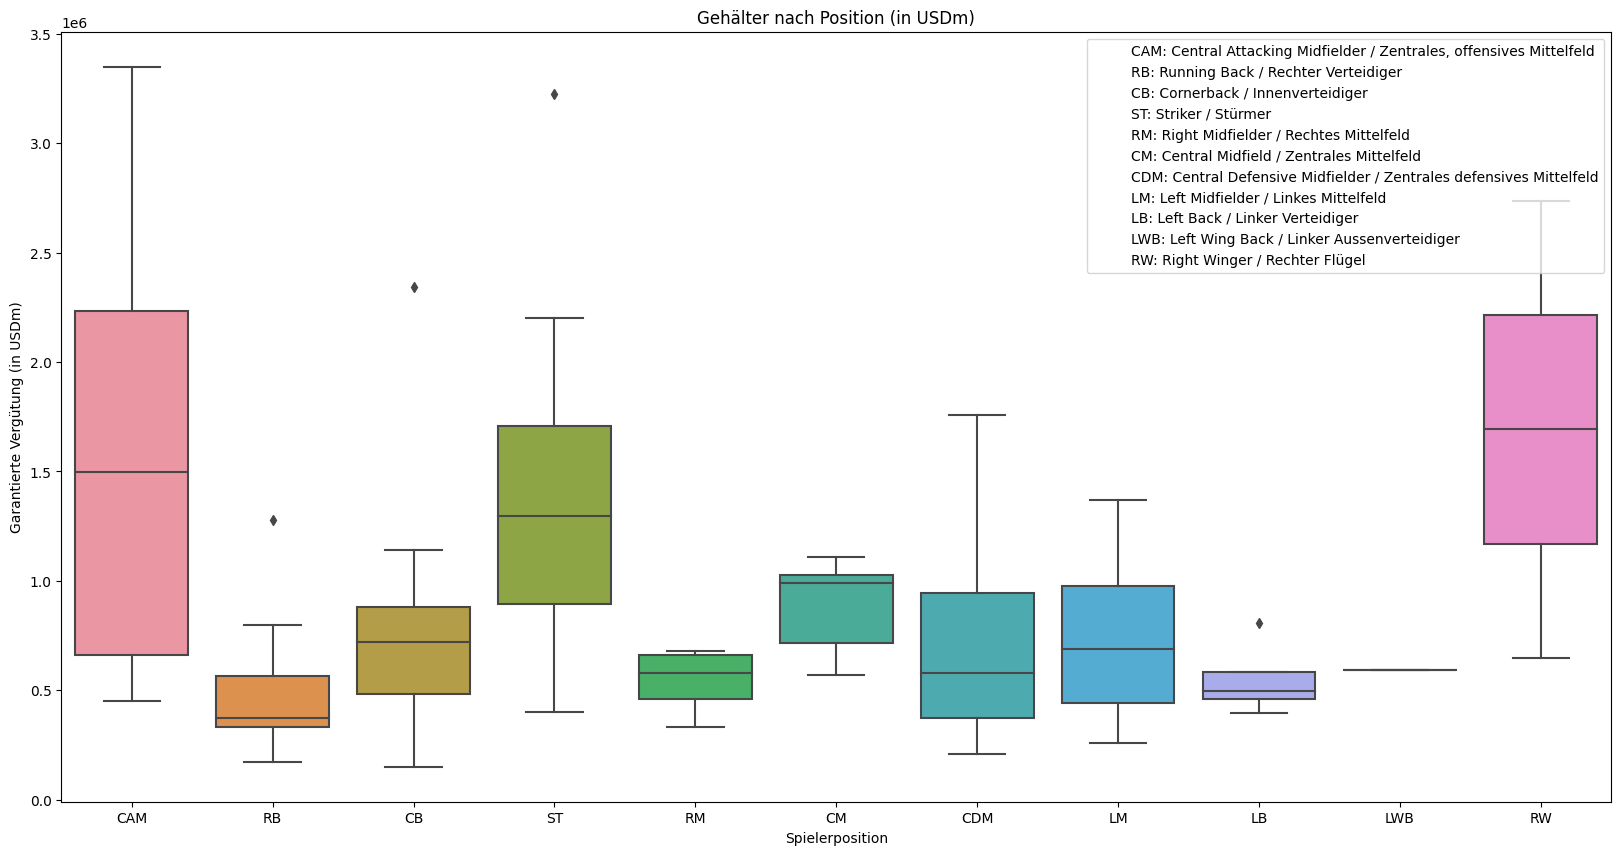

In [11]:
#@title 3.1 Visualisierung der Gehälter nach Position
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

if __name__ == "__main__":
    data_df = read_csv_file('05_cleaned_data_2.0.csv')

    plt.figure(figsize=(20, 10))
    sns.boxplot(x='position', y='Guaranteed Compensation', data=data_df)
    plt.title('Gehälter nach Position (in USDm)')
    plt.ylabel('Garantierte Vergütung (in USDm)')
    plt.xlabel('Spielerposition')

    # Legende hinzufügen
    cam_patch = mpatches.Patch(color='none', label='CAM: Central Attacking Midfielder / Zentrales, offensives Mittelfeld')
    rb_patch = mpatches.Patch(color='none', label='RB: Running Back / Rechter Verteidiger')
    cb_patch = mpatches.Patch(color='none', label='CB: Cornerback / Innenverteidiger')
    st_patch = mpatches.Patch(color='none', label='ST: Striker / Stürmer')
    rm_patch = mpatches.Patch(color='none', label='RM: Right Midfielder / Rechtes Mittelfeld')
    cm_patch = mpatches.Patch(color='none', label='CM: Central Midfield / Zentrales Mittelfeld')
    cdm_patch = mpatches.Patch(color='none', label='CDM: Central Defensive Midfielder / Zentrales defensives Mittelfeld')
    lm_patch = mpatches.Patch(color='none', label='LM: Left Midfielder / Linkes Mittelfeld')
    lb_patch = mpatches.Patch(color='none', label='LB: Left Back / Linker Verteidiger')
    lwb_patch = mpatches.Patch(color='none', label='LWB: Left Wing Back / Linker Aussenverteidiger')
    rw_patch = mpatches.Patch(color='none', label='RW: Right Winger / Rechter Flügel')

    plt.legend(handles=[cam_patch, rb_patch, cb_patch, st_patch, rm_patch, cm_patch, cdm_patch, lm_patch, lb_patch, lwb_patch, rw_patch], loc='upper right')

    plt.show()


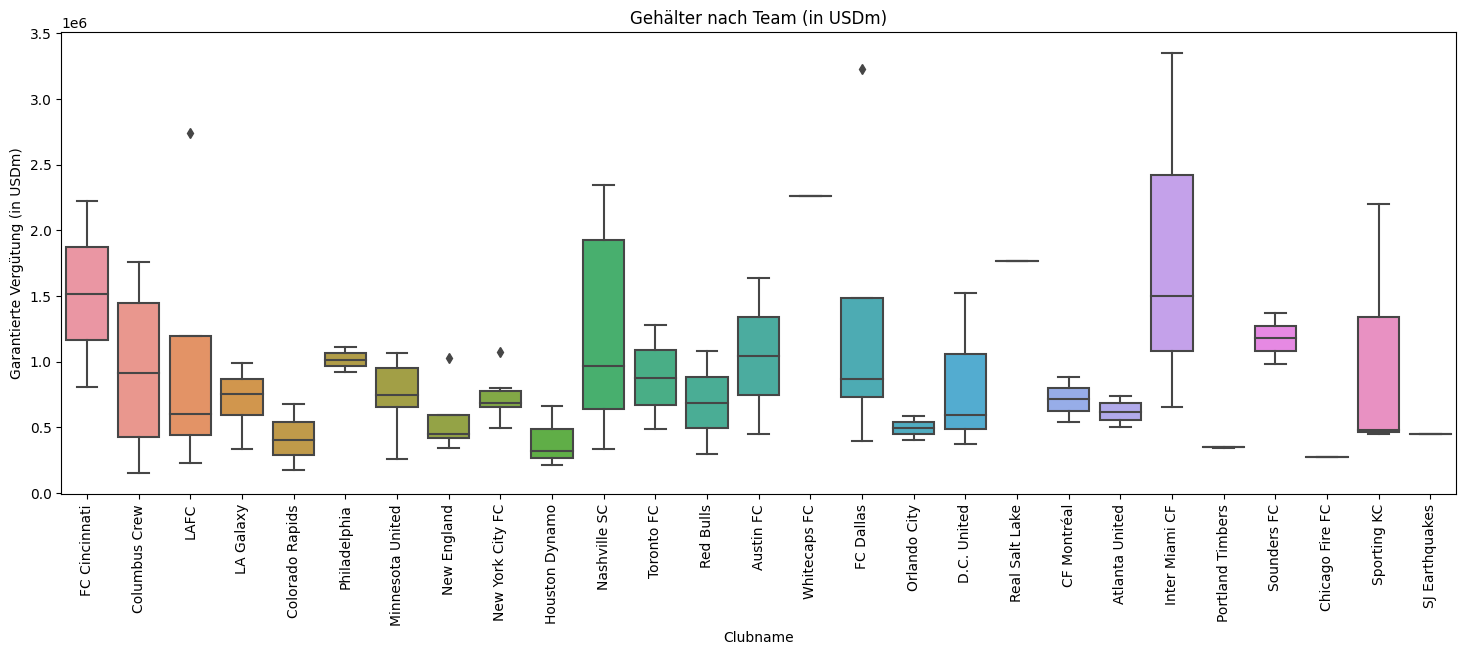

In [12]:
#@title 3.2 Visualisierung der Gehälter nach Club resp. Team
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

if __name__ == "__main__":
    data_df = read_csv_file('05_cleaned_data_2.0.csv')
    
    plt.figure(figsize=(18, 6))
    sns.boxplot(x='club', y='Guaranteed Compensation', data=data_df)
    plt.title('Gehälter nach Team (in USDm)')
    plt.ylabel('Garantierte Vergütung (in USDm)')
    plt.xlabel('Clubname')
    plt.xticks(rotation=90)
    plt.show()

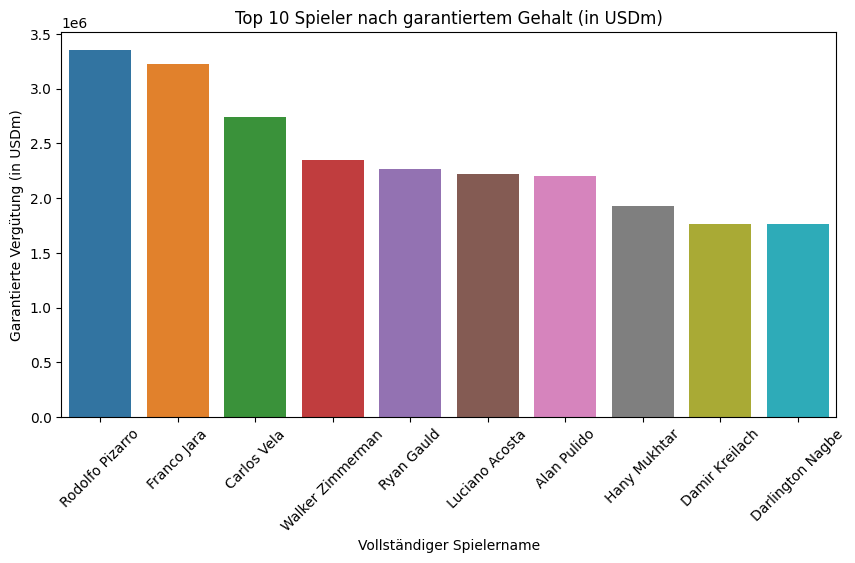

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

if __name__ == "__main__":
    data_df = read_csv_file('05_cleaned_data_2.0.csv')
    
    # Sortiere DataFrame nach garantiertem Gehalt absteigend und wähle die ersten 10 Zeilen aus
    top_10_players = data_df.sort_values('Guaranteed Compensation', ascending=False).head(10)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Name', y='Guaranteed Compensation', data=top_10_players)
    plt.title('Top 10 Spieler nach garantiertem Gehalt (in USDm)')
    plt.ylabel('Garantierte Vergütung (in USDm)')
    plt.xlabel('Vollständiger Spielername')
    plt.xticks(rotation=45)
    plt.show()


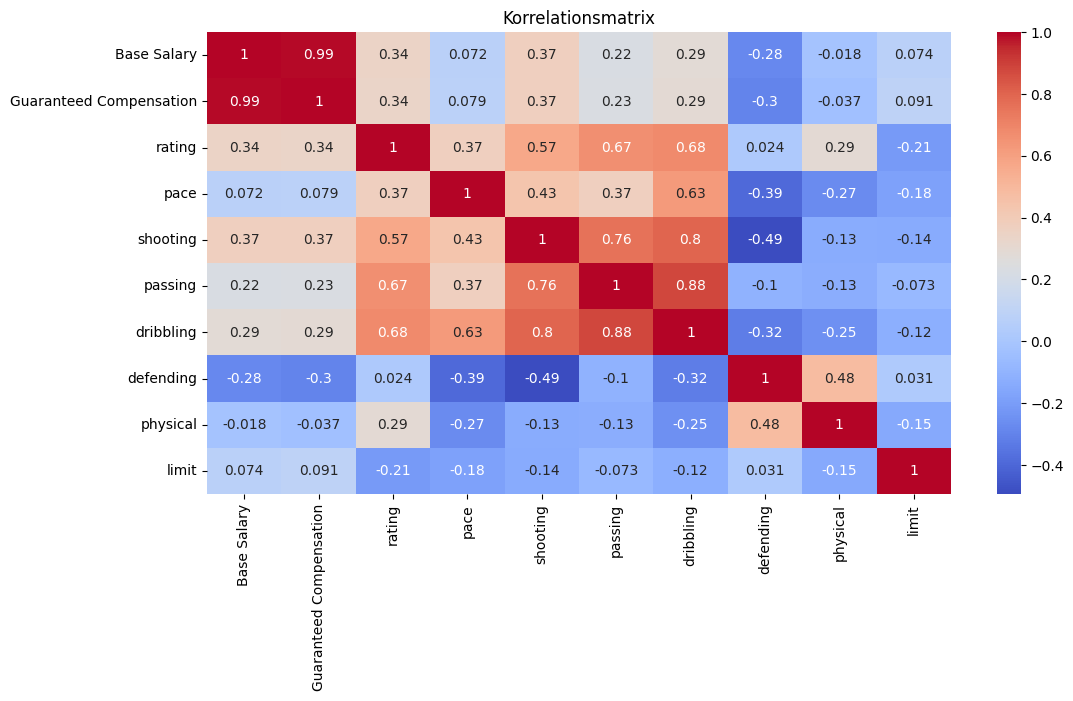

In [14]:
#@title 3.4 Korrelationsmatrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

if __name__ == "__main__":
    data_df = read_csv_file('05_cleaned_data_2.0.csv')

    corr_matrix = data_df.corr()
    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title('Korrelationsmatrix')
    plt.show()

### 3.5 Display of basic statistical values

Display basic statistical values, such as count, mean, standard deviation, minimum, 25th percentile, median (50th percentile), 75th percentile, and maximum for each numeric column in the dataset.

In [15]:
import pandas as pd

def read_csv_file(file_name):
    df = pd.read_csv(file_name)
    return df

def display_basic_statistics(df):
    print("Basic Statistical Values:\n")
    print(df.describe())

if __name__ == "__main__":
    cleaned_data_df = read_csv_file('05_cleaned_data_2.0.csv')
    display_basic_statistics(cleaned_data_df)


Basic Statistical Values:

        Base Salary  Guaranteed Compensation     rating       pace   shooting  \
count  8.100000e+01             8.100000e+01  81.000000  81.000000  81.000000   
mean   8.223241e+05             8.980305e+05  72.259259  71.975309  58.962963   
std    6.068752e+05             6.759509e+05   4.460319  13.000938  13.096225   
min    1.500000e+05             1.500000e+05  67.000000  36.000000  28.000000   
25%    4.250000e+05             4.500000e+05  69.000000  66.000000  50.000000   
50%    6.375000e+05             6.800000e+05  72.000000  74.000000  61.000000   
75%    9.000000e+05             1.066910e+06  74.000000  80.000000  68.000000   
max    3.050000e+06             3.350000e+06  89.000000  96.000000  87.000000   

         passing  dribbling  defending   physical        limit  
count  81.000000  81.000000  81.000000  81.000000    81.000000  
mean   64.925926  69.666667  58.382716  72.222222  1691.358025  
std     8.051052   8.637129  14.794060   9.01526

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


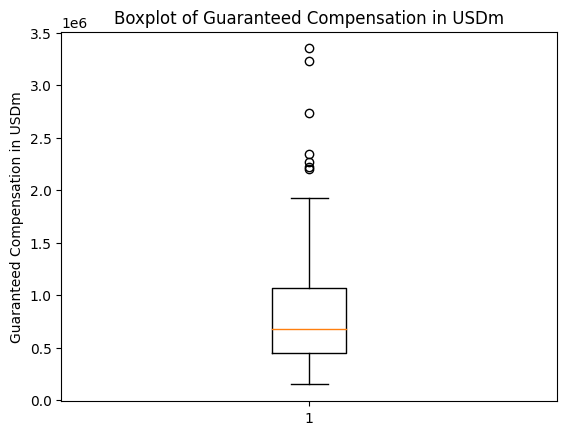

In [16]:
#@title 3.6 Boxplot
%pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt

def read_csv_file(file_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    return df

def convert_currency_to_float(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def display_boxplot(df, column_name):
    plt.boxplot(df[column_name])
    plt.title('Boxplot of Guaranteed Compensation in USDm')
    plt.ylabel('Guaranteed Compensation in USDm')
    plt.show()

if __name__ == "__main__":
    # Read the merged_data.csv file
    data_df = read_csv_file('05_cleaned_data_2.0.csv')

    # Display the boxplot of Guaranteed Compensation
    display_boxplot(data_df, 'Guaranteed Compensation')


New plot of boxplot without extreme values between 2.0 and 3.5. We will still keep those players in our df, as those are useful to train our prediction model in a later step.

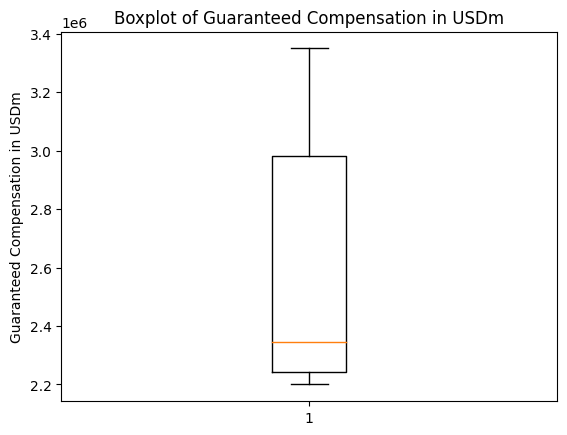

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def read_csv_file(file_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    return df

def convert_currency_to_float(df, column_name):
    df[column_name] = df[column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def remove_extreme_values(df, column_name, lower_bound, upper_bound):
    df = df.query(f'{lower_bound} <= `{column_name}` <= {upper_bound}')
    return df

def display_boxplot(df, column_name):
    plt.boxplot(df[column_name])
    plt.title('Boxplot of Guaranteed Compensation in USDm')
    plt.ylabel('Guaranteed Compensation in USDm')
    plt.show()

if __name__ == "__main__":
    # Read the merged_data.csv file
    data_df = read_csv_file('05_cleaned_data_2.0.csv')

    # Convert the 'Guaranteed Compensation' column to float
    data_df = convert_currency_to_float(data_df, 'Guaranteed Compensation')

    # Remove extreme values between 2 million and 3.5 million
    data_df = remove_extreme_values(data_df, 'Guaranteed Compensation', 2000000, 3500000)

    # Display the boxplot of Guaranteed Compensation after removing extreme values
    display_boxplot(data_df, 'Guaranteed Compensation')


### 3.7 Choropleth Map

Mapping der MLS Vereine auf US-Vectorkarte.

Da in unserem CSV-File keine Informationen zu den einzelnen US-Staaten vorhanden ist, müssen diese über eine third-party library namens Geopy geladen werden, sodass die Clubnamen für die nötige Identifizierung der US-Staaten genutzt werden kann.

In [18]:
import pandas as pd
import plotly.express as px

# Add full list of state abbreviations
all_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC']

club_state_mapping = {
    'Atlanta United': 'GA',
    'Austin FC': 'TX',
    'Chicago Fire': 'IL',
    'FC Cincinnati': 'OH',
    'Colorado Rapids': 'CO',
    'Columbus Crew': 'OH',
    'Charlotte FC': 'NC',
    'DC United': 'DC',
    'FC Dallas': 'TX',
    'Houston Dynamo': 'TX',
    'Inter Miami': 'FL',
    'LA Galaxy': 'CA',
    'LAFC': 'CA',
    'Los Angeles FC': 'CA',
    'Minnesota United': 'MN',
    'Nashville SC': 'TN',
    'New England Revolution': 'MA',
    'New York City FC': 'NY',
    'New York Red Bulls': 'NJ',
    'Orlando City SC': 'FL',
    'Philadelphia Union': 'PA',
    'Portland Timbers': 'OR',
    'Real Salt Lake': 'UT',
    'San Jose Earthquakes': 'CA',
    'Seattle Sounders FC': 'WA',
    'Sporting Kansas City': 'KS'
}

# Read the CSV file
df = pd.read_csv('05_cleaned_data_2.0.csv')

# Remove rows with specific club names
clubs_to_remove = ['Vancouver Whitecaps', 'Toronto FC', 'CF Montreal', 'Major League Soccer']
df = df[~df['club'].isin(clubs_to_remove)]

# Create a new column 'State' by mapping the 'Club' column to the club_state_mapping dictionary
df['State'] = df['club'].map(club_state_mapping)

# Save the updated dataframe to a new CSV file
df.to_csv('06_cleaned_data_with_states.csv', index=False)

# Calculate the average salary per state
average_salary_by_state = df.groupby('State')['Guaranteed Compensation'].mean().reset_index()
average_salary_by_state.columns = ['State', 'AverageSalary']

for state in all_states:
    if state not in average_salary_by_state['State'].values:
        average_salary_by_state = average_salary_by_state.append({'State': state, 'AverageSalary': 0}, ignore_index=True)

# Create a choropleth map
fig = px.choropleth(
    average_salary_by_state,
    locations='State',
    color='AverageSalary',
    locationmode='USA-states',
    scope='usa',
    color_continuous_scale='reds',
    title='Average MLS Salary by State in USDm:',
    labels={'AverageSalary': 'Average Salary in USDm'}
)

# Show the map
fig.show()


## (4) Speichern der Daten in einer PostgreSQL Database sowie SQL Abfragen aus dieser

### WICHTIG: Muss mit Docker Container ausgeführt werden

####Libraries and settings

In [19]:
# Libraries
import os
import fnmatch
import tempfile
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

os.environ['MPLCONFIGDIR'] = "/home/jovyan"
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(os.getcwd())

# Content of current working directory
fnmatch.filter(os.listdir('.'), '*.csv')

/content


['03_merged_data.csv',
 '20230513_salarySources.csv',
 '02_players.csv',
 '01_salaries.csv',
 '06_cleaned_data_with_states.csv',
 '04_cleaned_data.csv',
 '05_cleaned_data_2.0.csv']

#### Create database connection

In [20]:
conn = psycopg2.connect("host=db dbname=postgres user=admin password=secret")

OperationalError: ignored

#### Read data

In [ ]:
df = pd.read_csv('06_cleaned_data_with_states.csv', sep=',')
df.head(20)

#### Write data to database


In [ ]:
engine = create_engine('postgresql://admin:secret@db:5432/postgres')
df.to_sql('cleaned_data_table', engine, if_exists='replace')

#### Make SQL query

In [ ]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database
conn = psycopg2.connect(host="db", dbname="postgres", user="admin", password="secret")

# Create an SQL query to select all columns from the cleaned_data_table
sql_query = "SELECT * FROM cleaned_data_table"

# Create a Pandas dataframe by executing the SQL query and connecting to the PostgreSQL database
df = pd.read_sql_query(sql_query, con=conn)

# Print the first few rows of the dataframe
print(df.head())



In [ ]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database
conn = psycopg2.connect(host="db", dbname="postgres", user="admin", password="secret")

# Create an SQL query to select only the "Position(s)" column from the cleaned_data_table
sql_query = "SELECT \"Name\", \"rating\", \"Base Salary\" FROM cleaned_data_table"

# Create a Pandas dataframe by executing the SQL query and connecting to the PostgreSQL database
df = pd.read_sql_query(sql_query, con=conn)

# Print the first few rows of the dataframe
print(df.head(15))



In [ ]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database
conn = psycopg2.connect(host="db", dbname="postgres", user="admin", password="secret")

# Create an SQL query to select only the "Position(s)" column from the salary_table
sql_query = "SELECT \"Name\", \"rating\", \"Guaranteed Compensation\" FROM cleaned_data_table"

# Create a Pandas dataframe by executing the SQL query and connecting to the PostgreSQL database
df = pd.read_sql_query(sql_query, con=conn)

# Print the first few rows of the dataframe
print(df.head(15))


## (5) Verwendung eines ML Frameworks/Library

*tensorflow/keras oder sklearn*

##**Option 1**

###5.1 Definition for the creation, training and evaluation of a linear regression model

Creation of a simple deep neural network as well as tuning of the hyperparameters.

####5.1.1 Modules to be imported

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers # Keras acts as an interface for TensorFlow.
from matplotlib import pyplot as plt
import seaborn as sns

# The lines below are for improving reporting, and they are not strictly necessary. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Import completed.")

Import completed.


####5.1.2 Load the dataset

In [22]:
# Load the dataset from the CSV file
dataset = pd.read_csv("06_cleaned_data_with_states.csv")

# Rename the columns
dataset = dataset.rename(columns={"Base Salary": "base_salary", "Guaranteed Compensation": "guaranteed_compensation"})

# Split the dataset into train and test sets
train_df = dataset.sample(frac=0.7, random_state=42) # 70% for training
test_df = dataset.drop(train_df.index) # the remaining 30% for testing

# Display the first 10 rows of the training data
print(train_df.head(10))

# Calculate the correlation matrix of the training data
train_df.corr()

    base_salary  guaranteed_compensation                  Name  rating  \
4        575000                   678750         Julian Araujo      69   
35      1050000                  1080000            Aaron Long      75   
10       900000                  1076000  Valentin Castellanos      70   
0       1943500                  2222854        Luciano Acosta      75   
45       325000                   331562             Alex Muyl      68   
47       375000                   375000            Andy Najar      69   
66       625000                   687500          Pedro Santos      75   
53      2200000                  2200000           Alan Pulido      73   
50       252000                   350000     Cristhian Paredes      68   
28      1762572                  1762572        Damir Kreilach      74   

   position              club  pace  shooting  passing  dribbling  defending  \
4        RB         LA Galaxy    80        33       60         69         64   
35       CB         Red B

,base_salary,guaranteed_compensation,rating,pace,shooting,passing,dribbling,defending,physical,limit
base_salary,1.0,1.0,0.3,-0.0,0.3,0.1,0.2,-0.3,0.0,0.1
guaranteed_compensation,1.0,1.0,0.2,-0.0,0.3,0.1,0.2,-0.3,0.0,0.2
rating,0.3,0.2,1.0,0.4,0.5,0.6,0.7,0.2,0.3,-0.2
pace,-0.0,-0.0,0.4,1.0,0.4,0.3,0.6,-0.3,-0.2,-0.2
shooting,0.3,0.3,0.5,0.4,1.0,0.7,0.7,-0.4,-0.1,-0.1
passing,0.1,0.1,0.6,0.3,0.7,1.0,0.9,0.0,-0.1,-0.1
dribbling,0.2,0.2,0.7,0.6,0.7,0.9,1.0,-0.2,-0.3,-0.1
defending,-0.3,-0.3,0.2,-0.3,-0.4,0.0,-0.2,1.0,0.5,-0.0
physical,0.0,0.0,0.3,-0.2,-0.1,-0.1,-0.3,0.5,1.0,-0.1
limit,0.1,0.2,-0.2,-0.2,-0.1,-0.1,-0.1,-0.0,-0.1,1.0


####5.1.3 Correlation Matrix Plot (corrplot)

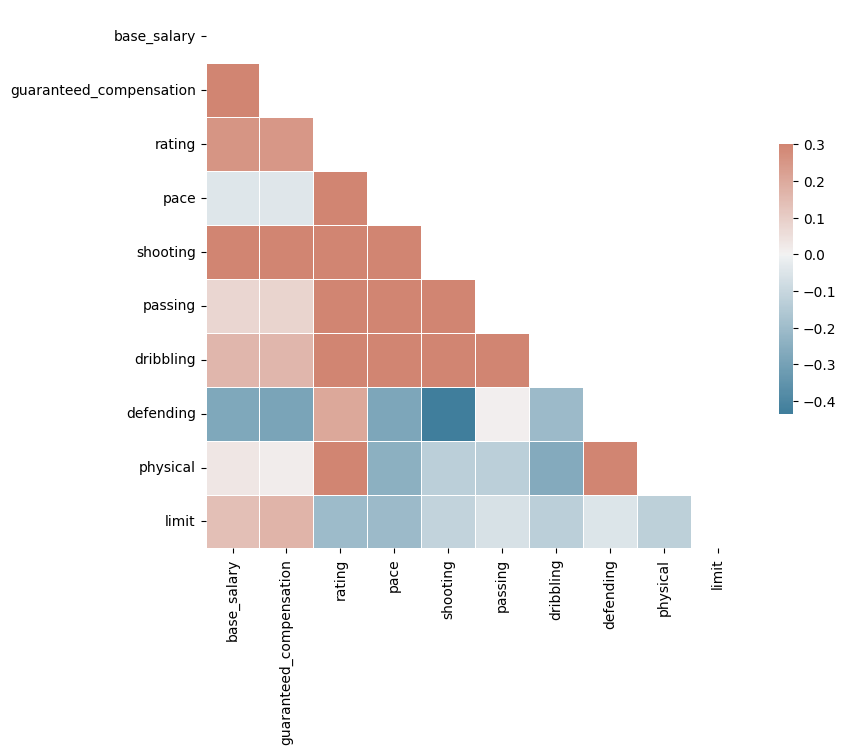

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the correlation matrix
corr = train_df.corr()

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


**Analysis of the Correlation Matrix Heatmap**

1. 'Base Salary' and 'Guaranteed Compensation' have a perfect positive correlation (1.0), indicating they increase or decrease together. This means that if a player's base salary is high, their guaranteed compensation is also likely to be high, and vice versa.
2.   'Rating' has a strong positive correlation with 'Dribbling' (0.7), 'Passing' (0.6), and 'Shooting' (0.5). This means that players with high ratings are likely to have high scores in dribbling, passing, and shooting. Similarly, 'Dribbling' is strongly correlated with 'Passing' (0.9) and 'Shooting' (0.7), indicating that good dribblers are likely to be good at passing and shooting as well.
3. The 'Defending' attribute has a negative correlation with 'Base Salary' and 'Guaranteed Compensation' (-0.3 in both cases). This could suggest that players with high defending scores might not necessarily receive high salaries or guaranteed compensations. However, this is a relatively weak negative correlation and could be due to various other factors not captured in this dataset.
4. 'Limit' doesn't seem to have any strong correlation with other attributes. All of its correlation coefficients are around -0.0 to 0.2, indicating no significant linear relationship with other variables.
5. 'Pace' is positively correlated with 'Rating', 'Shooting', 'Passing', and 'Dribbling', indicating that faster players tend to have better ratings and skills in these areas.

**Note:** These are just correlations. While they indicate relationships between variables, they don't prove causation. For instance, we can't say that high dribbling skills cause a player's rating to increase, just that they are associated. Other factors not included in the dataset could also be influencing these relationships.



####5.1.4 Standardization of data 

In [25]:
# Standardizing the training set, creating the so-called Z-scores (also called 
# standard scores or standardized values).

  # Definition Z-scores: statistical measure that quantifies the position of a 
  # data point within a distribution relative to the mean and standard
  # deviation of that distribution. Allows for the comparison of data points
  # from different distributions by normalizing them.

train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_stand = (train_df - train_df_mean)/train_df_std

# Doing the same for the test dataset
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_stand = (test_df - test_df_mean)/test_df_std

print("The data points have been standardized.")

The data points have been standardized.


####5.1.5 Arranging the data


The following code creates a feature layer containing **eight** features:

1.   median_base_salary
2.   rating
3.   shooting
4.   passing
5.   dribbling
6.   defending
7.   physical
8.   pace

The code specifies the features that we will train the model on and how each of those features will be represented. The transformations (collected in my_feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

**Note:** We will drop the columns 'Name', 'State', 'club', and 'position' from the DataFrames train_df_stand and test_df_stand because they contain missing values (NaNs) which prevent the model from being trained.

In [26]:
# Import TensorFlow
import tensorflow as tf

# Create an empty list that will eventually hold all created feature columns.
# The target will be defined apart.
feature_columns = []

# We standardized all the columns into their Z-scores. So, instead of picking
# a resolution in degrees, we're going to use resolution_in_Zs.
# A resolution_in_Zs of 1 corresponds to a full standard deviation. 

resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Represent median_base_salary as a floating-point value.
median_base_salary = tf.feature_column.numeric_column("median_base_salary")
feature_columns.append(median_base_salary)

# Represent rating as a floating-point value.
rating = tf.feature_column.numeric_column("rating")
feature_columns.append(rating)

# Represent shooting as a floating-point value.
shooting = tf.feature_column.numeric_column("shooting")
feature_columns.append(shooting)

# Represent passing as a floating-point value.
passing = tf.feature_column.numeric_column("passing")
feature_columns.append(passing)

# Represent dribbling as a floating-point value.
dribbling = tf.feature_column.numeric_column("dribbling")
feature_columns.append(dribbling)

# Represent defending as a floating-point value.
defending = tf.feature_column.numeric_column("defending")
feature_columns.append(defending)

# Represent physical as a floating-point value.
physical = tf.feature_column.numeric_column("physical")
feature_columns.append(physical)

# Represent pace as a floating-point value.
pace = tf.feature_column.numeric_column("pace")
feature_columns.append(pace)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Dropping of the columns 'Name', 'State', 'club', and 'position' from
# the DataFrames train_df_stand and test_df_stand
train_df_stand = train_df_stand.drop(columns=['Name', 'State', 'club', 'position'])
test_df_stand = test_df_stand.drop(columns=['Name', 'State', 'club', 'position'])

print("Columns with NaN that prevent training the model dropped.")


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Columns with NaN that prevent training the model dropped.


####5.1.6 Creation of the linear regression model 

In [27]:
import numpy as np
import pandas as pd

def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model
  
  # Call the function and assign the return value (model) to a variable named 'linear_regression_model'.
  linear_regression_model = create_model(my_learning_rate, feature_layer)

print("The linear regression model is now created.")


The linear regression model is now created.


####5.1.7 Training of the linear regression model

In [28]:
def train_model(model, dataset, epochs, batch_size, target_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(target_name))
  history = linear_regression_model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

Now, let us run the following code cell to invoke the functions defined in the preceding two code cells. (Please, ignore the warning messages.)

**Note:** Depending on the version of TensorFlow (in your local installation), running a similar cell could generate WARNING messages. You can ignore these warnings.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the DataFrame from the new CSV file
df_only_float = pd.read_csv('06_cleaned_data_with_states.csv')

# Replace this list with your actual numeric feature column names
numeric_feature_names = ['base_salary', 'rating', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical']

# Here we define the target.
target_name = "guaranteed_compensation"

# Prepare the feature columns
numeric_feature_columns = [tf.feature_column.numeric_column(key) for key in numeric_feature_names]

my_feature_layer = tf.keras.layers.DenseFeatures(numeric_feature_columns)

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 150
batch_size = 1000

# Establish the model's topography.
linear_regression_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're using the standardized datasets from the previous code.
# Ensure that the target_name matches the column name in the dataframe.
epochs, mse = train_model(linear_regression_model, train_df_stand, epochs, batch_size, target_name)

print("Our linear regression model is now trained.")


Epoch 1/150


1/1 [==============================] - 1s 849ms/step - loss: 1.2236 - mean_squared_error: 1.2236
Epoch 2/150
1/1 [==============================] - 0s 10ms/step - loss: 1.0551 - mean_squared_error: 1.0551
Epoch 3/150
1/1 [==============================] - 0s 8ms/step - loss: 0.9496 - mean_squared_error: 0.9496
Epoch 4/150
1/1 [==============================] - 0s 13ms/step - loss: 0.8692 - mean_squared_error: 0.8692
Epoch 5/150
1/1 [==============================] - 0s 12ms/step - loss: 0.8037 - mean_squared_error: 0.8037
Epoch 6/150
1/1 [==============================] - 0s 11ms/step - loss: 0.7465 - mean_squared_error: 0.7465
Epoch 7/150
1/1 [==============================] - 0s 13ms/step - loss: 0.6969 - mean_squared_error: 0.6969
Epoch 8/150
1/1 [==============================] - 0s 13ms/step - loss: 0.6525 - mean_squared_error: 0.6525
Epoch 9/150
1/1 [==============================] - 0s 14ms/step - loss: 0.6123 - mean_squared_error: 0.6123
Epoch 10/150
1/1 [======================

**Important:** Linear regression with keras does not provide the same amount of information we can get with sklearn.linear_model or statsmodels. The idea is simply to have a benchmark.

#### 5.1.8 Evaluation of the linear regression model


 Evaluate the linear regression model against the test set:


1/1 [==============================] - 0s 336ms/step - loss: 0.0045 - mean_squared_error: 0.0045


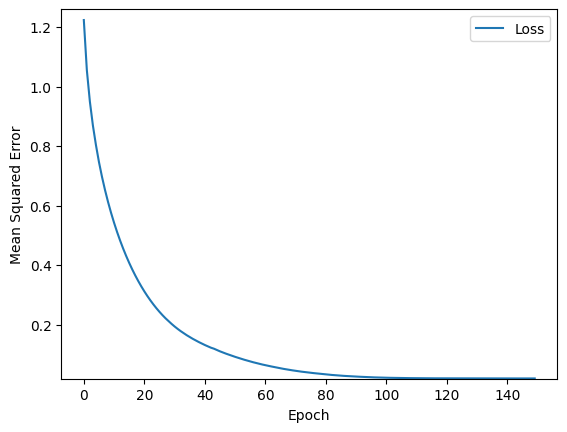

In [30]:
test_features = {name:np.array(value) for name, value in test_df_stand.items()}
test_label = np.array(test_features.pop(target_name)) # isolate the label

print("\n Evaluate the linear regression model against the test set:")
linear_regression_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

# Add the plot_the_loss_curve function definition
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()

plot_the_loss_curve(epochs, mse)

In [31]:
# Print the model's architecture
linear_regression_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_1 (DenseFeat  multiple                 0         
 ures)                                                           
                                                                 
 dense (Dense)               multiple                  9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


Outputs a table that shows each layer in the model, the output shape of each layer, and the number of parameters (weights and biases) in each layer. The table also includes totals for the number of parameters in the model.



In [32]:
# Get the weights and biases

# used to specify the second layer of the model (the Dense layer)
weights, biases = linear_regression_model.layers[1].get_weights()

print('Weights:\n', weights)
print('Biases:\n', biases)


Weights:
 [[ 0.9991494 ]
 [-0.03593203]
 [-0.09915385]
 [ 0.02798899]
 [ 0.09794173]
 [-0.02346699]
 [ 0.02057849]
 [-0.0116496 ]]
Biases:
 [0.0049932]


##**Option 2**

###5.2 Definition for the creation, training and evaluation of a deep neural network model

####5.2.1 Modules to be imported

In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The lines below are for improving reporting, and they are not strictly necessary. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Import completed.")

Import completed.


####5.2.2 Load the dataset

In [34]:
# Load the DataFrame from the new CSV file
df_only_float = pd.read_csv('06_cleaned_data_with_states.csv')

# Rename the columns
df_only_float = df_only_float.rename(columns={"Base Salary": "base_salary", "Guaranteed Compensation": "guaranteed_compensation"})

# Split the dataset into a training set and a testing set
train_df, test_df = train_test_split(df_only_float, test_size=0.2, random_state=42)

# Display the first 10 rows of the training data
print(train_df.head(10))

# Replace this list with your actual numeric feature column names
numeric_feature_names = ['Base_Salary', 'rating', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physical', 'limit']

# Here we define the target.
target_name = "guaranteed_compensation"

# Prepare the feature columns
numeric_feature_columns = [tf.feature_column.numeric_column(key) for key in numeric_feature_names]


    base_salary  guaranteed_compensation             Name  rating position  \
9        325000                   343813      Brandon Bye      89       RB   
5        650000                   680000  Michael Barrios      74       RM   
34       849996                   952496        Robin Lod      79       CM   
22       900000                   900000      Matt Hedges      72       CB   
30       850000                   965000     Randall Leal      70       LM   
40       300000                   344576  Santiago Moreno      69       LM   
39       600000                   662250  Alfredo Morales      72      CDM   
16       450000                   450000   Diego Fagundez      69      CAM   
65       400000                   493956      James Sands      70      CDM   
54       786000                   840627  Facundo Quignon      73      CDM   

                club  pace  shooting  passing  dribbling  defending  physical  \
9        New England    96        70       85         88    

####5.2.3 Correlation Matrix Plot (corrplot)

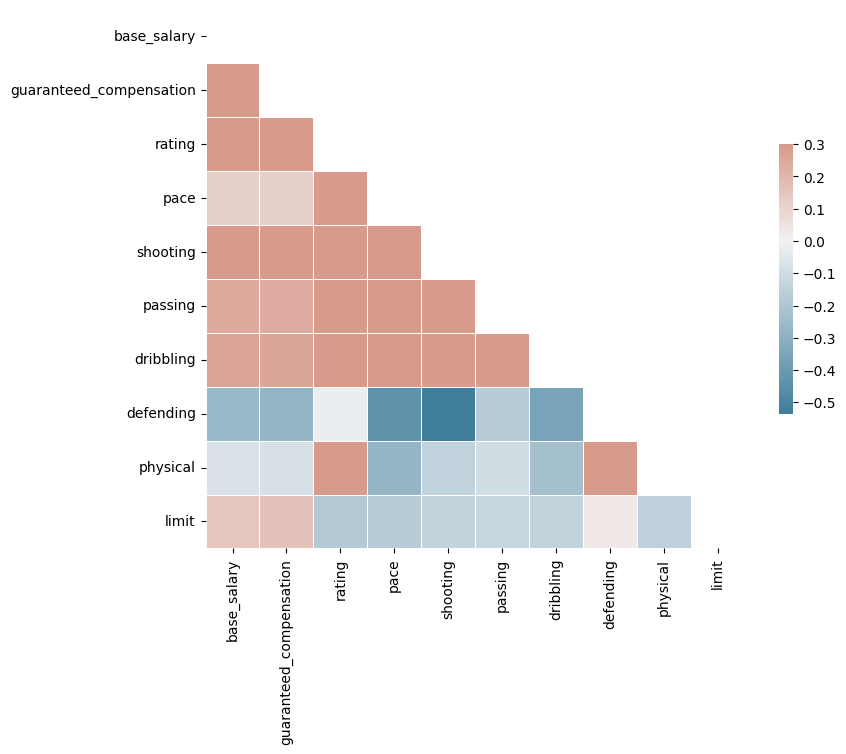

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix of the training data
train_df.corr()

# calculate the correlation matrix
corr = train_df.corr()

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


####5.2.4 Standardization of data

In [36]:
# Rename the column
train_df.rename(columns={'Base_Salary': 'base_salary'}, inplace=True)
test_df.rename(columns={'Base_Salary': 'base_salary'}, inplace=True)

# Replace 'Base_Salary' with 'base_salary' in numeric_feature_names
numeric_feature_names = ['base_salary' if feature == 'Base_Salary' else feature for feature in numeric_feature_names]

# Create numeric feature columns with the updated names
numeric_feature_columns = [tf.feature_column.numeric_column(key) for key in numeric_feature_names]

# Normalize the training and testing datasets
scaler = StandardScaler()
train_df_numeric = train_df[numeric_feature_names + [target_name]]
test_df_numeric = test_df[numeric_feature_names + [target_name]]

train_df_stand = pd.DataFrame(scaler.fit_transform(train_df_numeric), columns=train_df_numeric.columns)
test_df_stand = pd.DataFrame(scaler.transform(test_df_numeric), columns=test_df_numeric.columns)

my_feature_layer = tf.keras.layers.DenseFeatures(numeric_feature_columns)

print("Normalization of the training and testing dataset done.")


Normalization of the training and testing dataset done.


####5.2.5 Creation of the deep neural network model

In [38]:
def create_dnn_model(my_learning_rate, my_feature_layer):
    """Create and compile a simple network."""
    model = tf.keras.models.Sequential()

    model.add(my_feature_layer)

    model.add(tf.keras.layers.Dense(units=20,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden1'))

    model.add(tf.keras.layers.Dense(units=20,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden2'))

    model.add(tf.keras.layers.Dense(units=12,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden3'))

    model.add(tf.keras.layers.Dense(units=12,
                                    activation='tanh',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                    name='Hidden4'))

    model.add(tf.keras.layers.Dense(units=1,
                                    name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    return model
    print("DNN model created.")

####5.2.6 Training of the deep neural network model

In [39]:
def train_dnn_model(dnn_model, dataset, epochs, target_name, batch_size=None):
    features = {name: np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(target_name))
    history = dnn_model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)

    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

def plot_the_loss_curve(epochs, mse):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()

# The following variables are the hyperparameters.
learning_rate = 0.005
epochs = 150
batch_size = 1000
label_name = "guaranteed_compensation"

# Establish the model's topography.
dnn_model = create_dnn_model(learning_rate, my_feature_layer)

# Train the model on the standardized training set.
epochs, mse = train_dnn_model(dnn_model, train_df_stand, epochs, label_name, batch_size)

print("DNN model trained.")


Epoch 1/150


1/1 [==============================] - 1s 1s/step - loss: 4.4545 - mean_squared_error: 1.5077
Epoch 2/150
1/1 [==============================] - 0s 15ms/step - loss: 4.0366 - mean_squared_error: 1.1339
Epoch 3/150
1/1 [==============================] - 0s 26ms/step - loss: 3.8302 - mean_squared_error: 0.9750
Epoch 4/150
1/1 [==============================] - 0s 15ms/step - loss: 3.7091 - mean_squared_error: 0.9039
Epoch 5/150
1/1 [==============================] - 0s 13ms/step - loss: 3.6039 - mean_squared_error: 0.8501
Epoch 6/150
1/1 [==============================] - 0s 14ms/step - loss: 3.4922 - mean_squared_error: 0.7907
Epoch 7/150
1/1 [==============================] - 0s 13ms/step - loss: 3.3742 - mean_squared_error: 0.7250
Epoch 8/150
1/1 [==============================] - 0s 13ms/step - loss: 3.2552 - mean_squared_error: 0.6582
Epoch 9/150
1/1 [==============================] - 0s 14ms/step - loss: 3.1427 - mean_squared_error: 0.5976
Epoch 10/150
1/1 [========================

#### 5.2.7 Evaluation of the deep neural network model


 Evaluate the deep neural network model against the test set:
1/1 [==============================] - 0s 328ms/step - loss: 0.1710 - mean_squared_error: 0.0057


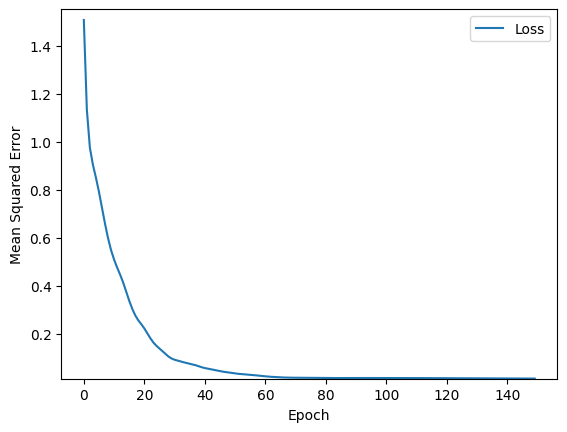


Evaluating the DNN model on the test set:
1/1 [==============================] - 0s 56ms/step - loss: 0.1952 - mean_squared_error: 0.0299

Test set Mean Squared Error: 0.0299
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_2 (DenseFeat  multiple                 0         
 ures)                                                           
                                                                 
 Hidden1 (Dense)             multiple                  200       
                                                                 
 Hidden2 (Dense)             multiple                  420       
                                                                 
 Hidden3 (Dense)             multiple                  252       
                                                                 
 Hidden4 (Dense)             multiple                  156       
          

In [40]:
print("\n Evaluate the deep neural network model against the test set:")
dnn_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

plot_the_loss_curve(epochs, mse)

# First, obtain the model's predictions on the test set
test_features = {name: np.array(value) for name, value in test_df_stand.items()}
test_label = np.array(test_features.pop(label_name))

# Verify the new DNN model against the test set:
print("\nEvaluating the DNN model on the test set:")
evaluation_results = dnn_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)
print("\nTest set Mean Squared Error: {:.4f}".format(evaluation_results[1]))

# Print the DNN model's architecture
dnn_model.summary()

# Get the weights and biases
# Note that we now have multiple layers of weights and biases
for i, layer in enumerate(dnn_model.layers[1:]):
    weights, biases = layer.get_weights()
    print('Layer {}:'.format(i+1))
    print('Weights:\n', weights)
    print('Biases:\n', biases)
    print('-------------------------------')

##(6) Comparison: Linear Regression Model vs. Deep Neural Network

**Korrekte Interpretation der Modellergebnisse und Modellgütemasse**

Die Ergebnisse des Vergleichs zwischen dem Linear Regression Model und dem Deep Neural Network (DNN) im Zusammenhang mit den MLS-Daten sind wie folgt:

Linear Regression Model:
•	Loss: 0.0045
•	Mean Squared Error: 0.0045

Deep Neural Network Model:
•	Loss: 0.1710
•	Mean Squared Error: 0.0057

Interpretation:
Das Linear Regression Model zeigt eine geringere Loss-Funktion und einen geringeren Mean Squared Error im Vergleich zum DNN-Modell. Dies bedeutet, dass das lineare Regressionsmodell besser auf die Daten der MLS passt und eine genauere Vorhersagekraft aufweist.
Es ist jedoch zu beachten, dass das DNN-Modell möglicherweise noch Raum für Verbesserungen bietet. Die Architektur des DNN-Modells besteht aus mehreren Schichten, die eine gewisse Flexibilität und Komplexität bieten, aber auch dazu führen können, dass das Modell anfälliger für Overfitting wird.



**--> Text zur Evaluation schreiben**
**--> Beide Modelle zusammen diskutieren**
geeigneter Modellgütemasse: Metriken

Die Auswahl der geeigneten Metrik hängt von der Art der Aufgabe und den spezifischen Anforderungen des Projekts ab. Hier sind einige gängige Modellgütemaße für verschiedene Aufgaben:

1. Regression:
* Mean Absolute Error (MAE): Durchschnittlicher absoluter Fehler zwischen den vorhergesagten und tatsächlichen Werten.
* Mean Squared Error (MSE): Durchschnittlicher quadratischer Fehler zwischen den vorhergesagten und tatsächlichen Werten.
* Root Mean Squared Error (RMSE): Quadratwurzel des durchschnittlichen quadratischen Fehlers.
* R-Squared (R^2) oder Bestimmtheitsmaß: Anteil der Varianz in den abhängigen Variablen, der durch das Modell erklärt wird.
* Mean Absolute Percentage Error (MAPE): Durchschnittlicher prozentualer Fehler zwischen den vorhergesagten und tatsächlichen Werten.

Comparing and evaluating a linear regression model and a deep neural network involves considering various factors. Here are some points to help you compare and evaluate these two types of models:

1. Complexity and flexibility: Linear regression is a simple, linear model that assumes a linear relationship between the independent and dependent variables. It has limited flexibility in capturing complex patterns in the data. On the other hand, deep neural networks are highly flexible and can learn complex nonlinear relationships between variables. They can automatically extract relevant features from the data, making them more suitable for capturing intricate patterns.

2. Model performance: Evaluate the performance of both models using appropriate metrics such as R-squared, mean squared error (MSE), root mean squared error (RMSE), or any other relevant metric. Compare these metrics for both models on a common evaluation dataset. If the deep neural network outperforms the linear regression model significantly, it indicates that the nonlinear relationships captured by the neural network are better suited for the data.

3. Overfitting: Deep neural networks are prone to overfitting, especially when working with limited data. Overfitting occurs when the model learns the training data too well but fails to generalize to unseen data. Linear regression, being a simpler model, is less prone to overfitting. To assess and compare the risk of overfitting, you can use techniques such as cross-validation and evaluate the models on a separate test dataset.

4. Interpretability: Linear regression models provide straightforward interpretability. The coefficients represent the relationship and impact of each independent variable on the dependent variable. On the other hand, deep neural networks are often considered black-box models, as they involve multiple layers and complex interactions. Interpreting the relationships and understanding the decision-making process of a neural network can be challenging.

5. Data requirements: Linear regression models typically require fewer data points to estimate the model parameters accurately. Deep neural networks, especially large and complex architectures, usually require more data to train effectively. If you have limited data, a simpler linear regression model might be more appropriate.

6. Computational requirements: Deep neural networks, especially deep architectures with numerous layers, can be computationally intensive and require substantial computational resources for training and inference. Linear regression models are generally computationally lightweight and can be quickly implemented and executed.

7. Context and problem complexity: Consider the context of your problem and the complexity of the relationships you want to capture. Linear regression models work well when the relationships are relatively simple and linear. Deep neural networks are more suitable for complex tasks that involve nonlinear relationships, such as image recognition, natural language processing, or time series forecasting.

8. Training time: Deep neural networks often require longer training times compared to linear regression models, especially for complex architectures and large datasets. Consider the available computational resources and time constraints when comparing and evaluating the models.

Ultimately, the choice between a linear regression model and a deep neural network depends on the nature of your data, the complexity of the problem, the interpretability requirements, the available computational resources, and the desired performance. It is recommended to experiment with both models, evaluate their performance on relevant metrics, and select the one that best suits your specific needs.

## (7) Convolutional Neural Networks (CNN)

In [ ]:
# Import modules
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
import random

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from PIL import Image
from pathlib import Path


from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from  matplotlib import pyplot as plt

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

# import some additional tools specifically for CNN

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten, BatchNormalization




%matplotlib inline



## Load image, create new data points with image augmentation, save new datapoints

# load the image
img = Image.open('./logos/Vancouver Whitecaps FC/Vancouver Whitecaps FC.png')
#img = load_img('./logos/Vancouver Whitecaps FC/Vancouver Whitecaps FC.png') -> nicht gut, weil transparenter Hintergrund

# convert the image to RGB or RGBA format
#img = img.convert('RGB')  # for images without transparency
img = img.convert('RGBA')  # for images with transparency

# convert the image to a numpy array
x = img_to_array(img)

# reshape the array to fit the dimensions expected by Keras
x = x.reshape((1,) + x.shape)

# create a data generator for augmenting the image
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# generate 5 augmented images and save them to a directory
i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='./logos/Vancouver Whitecaps FC', save_prefix='aug', save_format='png'):
    i += 1
    if i > 2:
        break

main_directory = "./logos"

#Recursive
main_directory = "./logos"

for path in Path(main_directory).rglob('*.png'):
    #print(path)
    ## Load image, create new data points with image augmentation, save new datapoints

    # load the image
    img = Image.open(path)
    #img = load_img('./logos/Vancouver Whitecaps FC/Vancouver Whitecaps FC.png') -> nicht gut, weil transparenter Hintergrund

    # convert the image to RGB or RGBA format
    #img = img.convert('RGB')  # for images without transparency
    img = img.convert('RGBA')  # for images with transparency

    # convert the image to a numpy array
    x = img_to_array(img)

    # reshape the array to fit the dimensions expected by Keras
    x = x.reshape((1,) + x.shape)

    # create a data generator for augmenting the image
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # generate 5 augmented images and save them to a directory
    i = 0
    for batch in train_datagen.flow(x, batch_size=1, save_to_dir=path.parent, save_prefix='aug', save_format='png'):
        i += 1
        
        if i > 99:
            break

# Bilder laden

def load_images_from_folder(folder_path, label_map=None, label_index=0):
    images = []
    labels = []
    
    if label_map is None:
        label_map = {}

    
    for filename in os.listdir(folder_path):
        path = os.path.join(folder_path, filename)
        if os.path.isdir(path):
            # Recursively load images from subdirectory
            sub_images, sub_labels, label_map, label_index = load_images_from_folder(path, label_map=label_map, label_index=label_index)
            images.extend(sub_images)
            labels.extend(sub_labels)
        else:
            # Load image
            img = cv2.imread(path)
            if img is not None:
                # Resize image
                img = cv2.resize(img, (100, 100)) # images zu einheitlicher grösse resizen
                # Normalize pixel values
                img = img.astype('float32') / 255
                # Add image and label to lists
                images.append(img)
                label = folder_path.split("\\")[1]
                #print(label)
                if label not in label_map:
                    label_map[label] = label_index
                    label_index += 1
                labels.append(label_map[label])
    
    num_classes = len(label_map)
    #print(len(images))
    #print(num_classes)
    #print(label_map)
    return np.array(images), np.array(labels), label_map, num_classes


#dataset = load_images_from_folder(main_directory)

# Load images and labels
images, labels, label_map, num_classes = load_images_from_folder(main_directory)


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

print(Y_test)
#from tensorflow.keras.utils import to_categorical
#labels = to_categorical(labels, num_classes)


# Convert labels to categorical data / one-hot format classes
num_classes = len(set(label_map))
#print(num_classes)
#print(label_map)
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print(num_classes)
print(X_train.shape)
print(Y_train.shape)

print(Y_train[19])

model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(100,100,3))) # 32 different 3x3 kernels -- so 32 feature maps
# 2-d convolution, also Filter mit 2d matrix
# bei 3d bild dann ein filter mit 3d matrix
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation, normalisiere convolved featrue Matrixen von filter
convLayer01 = Activation('relu')                     # activation function
#wichtig: Je nach Filter/kernel (z.B. Wikipedia -> Sharpen) kann ich mit negativen Nummern enden 
#-> ActivationFunction entsprechend wählen
model.add(convLayer01)

# Convolution Layer 2 -> input = 32 feature maps aus layer1, handle also nicht mehr direkt ursprügliches image
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
# pooling = shrink size of matrix
model.add(convLayer02)

# Convolution Layer 3 (so a proper deep network)
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector
# switche erst hier von Matrix zu Vektor, in P1 habe ich das am Anfang gemacht

# Fully Connected Layer 5 -> connects to all outputs of Layer4
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6 (output)                      
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(28))                                 # final 28 FCN nodes -> weil 28 clubs
model.add(Activation('softmax'))                     # softmax activation


model.summary()

# we'll use the same optimizer as before (Colab 1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
#crossentropy = vektoren vergleichen

print(X_train.shape)
print(Y_train.shape)

model.fit(X_train, Y_train,
          batch_size=128, epochs=10, # je kleiner der batch desto länger brauchts
          # 1 epoche = 1x forward & 1x backward propagation
          verbose=1)
# verbose is used to see the progress of the process ('auto', 0, 1, 2)
# 469 = 60'000/128 -> wenn nicht genau aufgeht, dann hat letzter Batch einfach so viele Datensätze wie noch übrig

score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Get more Datapoints

datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.3,
                             height_shift_range=0.3, shear_range=0.3,
                             zoom_range=0.3, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator()

# Generate augmented images from your original dataset
train_generator = datagen.flow(X_train, Y_train, batch_size=128)
test_generator = test_datagen.flow(X_train, Y_train, batch_size=128)



# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit(train_generator, steps_per_epoch=2000//128, epochs=10, verbose=1, 
                    validation_data=test_generator, validation_steps=563//128) 
# at home try epochs>=10

score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])


# Test CNN
image_url = 'https://images.mlssoccer.com/image/upload/t_q-best/v1614970751/assets/logos/1708-vancouver-logo_znac8n.png' 
# you can choose your own image
image_url = tf.keras.utils.get_file('Vancouver Whitecaps FC', origin=image_url) # we know it is a cat, will Python recognize it?
img = tf.keras.preprocessing.image.load_img( image_url, target_size=(100, 100))
plt.imshow(img)


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it is the only member.


predictions = model.predict(img_array)
score = predictions[0]

print(score)
#print(label_map)


## (8) Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [41]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 5.15.107+
Datetime: 2023-05-13 09:43:25
Python Version: 3.10.11
-----------------------------------
